<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 11 - Redes Neurais Convolucionais

## 11.3 - Transferência de Aprendizado

Geralmente, os modelos baseados em aprendizado profundo para processamento de imagens e textos necessitam de serem treinados a partir de grandes conjuntos de dados para se atingir resultados satisfatórios. Essa grande quantidade processamento está relacionada tanto com a memória, como ao tempo gasto.

Além disso, em diversas tarefas supervisionadas (classificação, PoS Tagging etc) pode ser difícil encontrar conjuntos de dados rotulados para o treinamento dos modelos.

A estratégia de **aprendizado por transferência** *(transfer learning)* tenta simular a habilidade humana de adquirir conhecimento durante o aprendizado de uma tarefa e assim utilizá-lo para resolver um problema (tarefa) relacionada. Veja uma comparação entre o aprendizado tradicional e o aprendizado por transferência na figura abaixo:



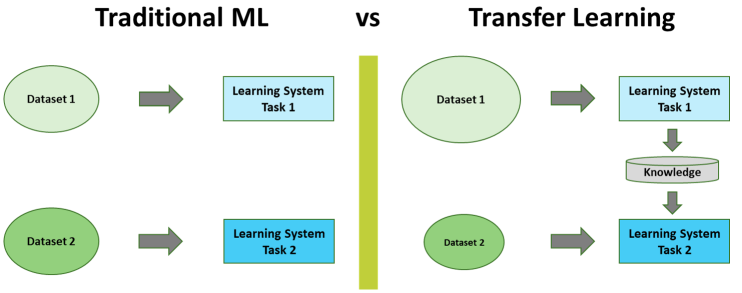

Fonte: [Humboldt Universität](https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/#motivation)

Observe que no aprendizado tradicional, o conhecimento obtido é utilizado exclusivamente nos modelos induzidos para a tarefa supervisionada. Já na transferência por aprendizado, o conhecimento obtido dos dados de treinamento no **modelo 1** e que estão armazendos, por exemplo, nos seus pesos, pode ser utilizado para treinar um **modelo 2**. Define-se que no modelo **1** é denominado como fonte do conhecimento e o **modelo 2** é a tarefa alvo.

Considera-se que no aprendizado por transferência indutivo, a fonte de conhecimento deve ser diferente da tarefa alvo e os dados rotulados tem que estar disponíveis no domínio do conhecimento da tarefa alvo. Por exemplo, considere a simples tarefa de um modelo de linguagem: a partir de um diveras palavras em uma língua e em um determinado domínio (contexto), deve-se prever a próxima palavra. Se estamos lidando com análise de sentimentos de tweets, podemos utilizar um corpus formado por artigos da Wikipedia para gerar o conhecimento para o modelo de linguagem. Podemos utilizar um modelo cujos pesos são resultantes do processo de treinamento nesse corpus da Wikipedia. Para customizar o modelo de linguagem para a tarefa alvo (análise de sentimentos, classificação de emoções ou de polaridade), devemos empregar um conjunto de tweets rotulados.

Informações sobre a coleção de imagens utilizada. É uma amostragem aleatória do conjunto

In [24]:
!pip install -U keras
!pip install tensorflow

### Leitura das imagens

Veja informações sobre a leitura das imagens e a organização das pastas do dataset nesse [Python Notebook](lectures/cap11_2_cnn_alexnet.ipynb). Não faremos nada diferente por enquanto.

Supondo que a pasta "documents" esteja no Google Drive, vamos montar o drive e copiar a pasta para o ambiente no Colab:

In [25]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
!cp -r '/content/drive/MyDrive/ocr/full_3/' 'documents'

Fazendo-se os imports necessários:

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Leitura de dados

In [28]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [29]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [30]:
X = df['filename'].values
y = df['label'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=45)

Criação dos logits dos labels

In [32]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [33]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [34]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [35]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                              shuffle=False)


Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


Hyperparameters

In [36]:
dims = (224,224,3)
num_classes = 3

### Residual Networks (ResNet)

Na tarefa alvo que é a classificação de imagens de documentos, vamos utilizar uma arquitetura diferente: a [Deep Residual Neural Network (ResNet)](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html). Os blocos residuais foram criados para resolver o problema dos gradientes durante o backpropagation que podem crescer demasiadamente (*explodir*) ou diminuir demasiadamente (*vanishing*). A ideia desse bloco consiste em criar conexões de pulam algumas camadas das redes. Com isso diferentes níveis 


A Figura abaixo ilustra a arquitetura de uma ResNet-34. Existem diferentes variações da arquitetura ResNet, mas que apresentam o mesmo conceito de empregar blocos residuais com uma quantidade diferentes de camadas. Isso significa que no nome "ResNet-X", X é um número inteiro que denota a quantidade de camadas da rede neural. Por exemplo, a literatura reporta também as arquiteturas ResNet-18, ResNet-50, ResNet-101, ResNet-110, ResNet-152, ResNet-164, ResNet-1202 etc.




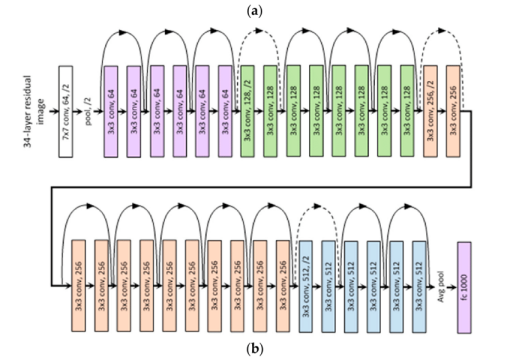

Fonte: [Medium](https://medium.com/@siddheshb008/resnet-architecture-explained-47309ea9283d)

In [37]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())

model_resnet_pt.add(Dense(num_classes))
model_resnet_pt.add(Activation("softmax"))

In [38]:
model_resnet_pt.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
 activation_3 (Activation)   (None, 3)                 0         
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [39]:
sgd = SGD(learning_rate=0.0001)

model_resnet_pt.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model_resnet_pt.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/30
65/65 [==============================] - 18s 238ms/step - loss: 1.0801 - accuracy: 0.4870 - val_loss: 1.0669 - val_accuracy: 0.4507
Epoch 2/30
65/65 [==============================] - 15s 232ms/step - loss: 1.0531 - accuracy: 0.4638 - val_loss: 1.0443 - val_accuracy: 0.4423
Epoch 3/30
65/65 [==============================] - 12s 177ms/step - loss: 1.0327 - accuracy: 0.4817 - val_loss: 1.0245 - val_accuracy: 0.4761
Epoch 4/30
65/65 [==============================] - 12s 176ms/step - loss: 1.0138 - accuracy: 0.5063 - val_loss: 1.0054 - val_accuracy: 0.5296
Epoch 5/30
65/65 [==============================] - 12s 176ms/step - loss: 0.9964 - accuracy: 0.5410 - val_loss: 0.9895 - val_accuracy: 0.5352
Epoch 6/30
65/65 [==============================] - 12s 176ms/step - loss: 0.9799 - accuracy: 0.5560 - val_loss: 0.9710 - val_accuracy: 0.5634
Epoch 7/30
65/65 [==============================] - 12s 176ms/step - loss: 0.9643 - accuracy: 0.5705 - val_loss: 0.9551 - val_accuracy: 0.5746

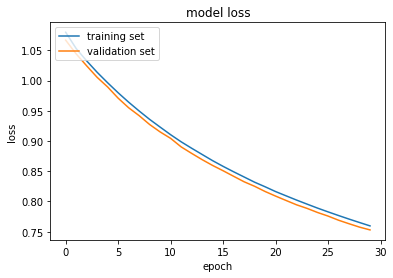

In [40]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Provavelmente temos um underfitting... tentando de novo

In [41]:
y_prob = model_resnet_pt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

y_test = test_generator.classes
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       171
           1       0.78      0.85      0.81       193
           2       0.67      0.69      0.68       170

    accuracy                           0.76       534
   macro avg       0.76      0.76      0.76       534
weighted avg       0.76      0.76      0.76       534



In [52]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape=(224,224,3),
    include_top=False,
    pooling ='avg',
    weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())

model_resnet_pt.add(Dense(512))
model_resnet_pt.add(Activation("relu"))
model_resnet_pt.add(Dropout(0.5))

model_resnet_pt.add(Dense(num_classes))
model_resnet_pt.add(Activation("softmax"))

In [53]:
sgd = SGD(learning_rate=0.001)

model_resnet_pt.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine =model_resnet_pt.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=valid_generator)

Epoch 1/30
65/65 [==============================] - 18s 187ms/step - loss: 1.1333 - accuracy: 0.4348 - val_loss: 0.8460 - val_accuracy: 0.8000
Epoch 2/30
65/65 [==============================] - 11s 173ms/step - loss: 0.9201 - accuracy: 0.5738 - val_loss: 0.7418 - val_accuracy: 0.8366
Epoch 3/30
65/65 [==============================] - 11s 172ms/step - loss: 0.7940 - accuracy: 0.6689 - val_loss: 0.6875 - val_accuracy: 0.8338
Epoch 4/30
65/65 [==============================] - 11s 171ms/step - loss: 0.7393 - accuracy: 0.7046 - val_loss: 0.6407 - val_accuracy: 0.8451
Epoch 5/30
65/65 [==============================] - 11s 173ms/step - loss: 0.6806 - accuracy: 0.7606 - val_loss: 0.6238 - val_accuracy: 0.8197
Epoch 6/30
65/65 [==============================] - 11s 171ms/step - loss: 0.6452 - accuracy: 0.7794 - val_loss: 0.5993 - val_accuracy: 0.8056
Epoch 7/30
65/65 [==============================] - 11s 171ms/step - loss: 0.6154 - accuracy: 0.7949 - val_loss: 0.5655 - val_accuracy: 0.8423

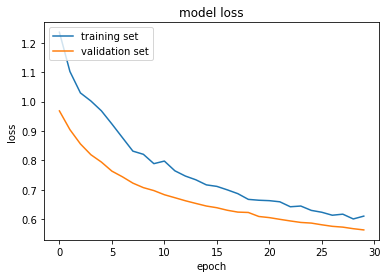

In [49]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Avaliação de performance com os dados de teste

In [50]:
y_prob = model_resnet_pt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       171
           1       0.83      0.83      0.83       193
           2       0.68      0.81      0.74       170

    accuracy                           0.79       534
   macro avg       0.80      0.79      0.79       534
weighted avg       0.80      0.79      0.79       534

